In [1]:
import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import glob
import random
df_annotations = pd.read_csv('/kaggle/input/luna16/annotations.csv')
df_annotations_sorted = df_annotations.sort_values(by='diameter_mm', ascending=False)
# Define cube size
cube_size = 32
output_folder = "/kaggle/working/npy_files"
os.makedirs(output_folder, exist_ok=True)
csv_entries = []
def process_and_save_roi(roi, series_uid, idx, label):
    filename = os.path.join(output_folder, f"{series_uid}_{label}_{idx}.npy")
    np.save(filename, roi)
    return filename


In [ ]:
def generate_random_coordinates(ct_scan, cube_size):
    z_max, y_max, x_max = ct_scan.shape
    if z_max < 2*cube_size or y_max < 2*cube_size or x_max < 2*cube_size:
        return None, None, None
    rand_z = random.randint(cube_size, z_max - 2 * cube_size)
    rand_y = random.randint(cube_size, y_max - 2 * cube_size)
    rand_x = random.randint(cube_size, x_max - 2 * cube_size)
    return rand_z, rand_y, rand_x
for idx, row in df_annotations_sorted.iterrows():
    series_uid = row['seriesuid']
    nodule_center_world = np.array([row['coordZ'], row['coordY'], row['coordX']])
    
    filepaths = glob.glob(f'/kaggle/input/luna16/subset*/*/{series_uid}.mhd')
    if not filepaths:
        continue
    mhd_file_path = filepaths[0]
    mhd_file = sitk.ReadImage(mhd_file_path)
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    origin = np.array(list(reversed(mhd_file.GetOrigin())))
    spacing = np.array(list(reversed(mhd_file.GetSpacing())))
    stretched_voxel_coordinates = np.absolute(nodule_center_world - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    irc = tuple(map(int, np.round(voxel_coordinates)))
    roi = ct_scan[
        max(0, irc[0]-cube_size):min(irc[0]+cube_size, ct_scan.shape[0]),
        max(0, irc[1]-cube_size):min(irc[1]+cube_size, ct_scan.shape[1]),
        max(0, irc[2]-cube_size):min(irc[2]+cube_size, ct_scan.shape[2]),
    ]
    if roi.shape == (2*cube_size, 2*cube_size, 2*cube_size):
        filepath = process_and_save_roi(roi, series_uid, idx, 1)
        csv_entries.append({'file': filepath, 'class': 1})

In [ ]:
# Generate non-nodules
non_nodule_count = 0
target_non_nodule_count = 500
all_series_uids = df_annotations_sorted['seriesuid'].unique()
while non_nodule_count < target_non_nodule_count:
    series_uid = random.choice(all_series_uids)
    filepaths = glob.glob(f'/kaggle/input/luna16/subset*/*/{series_uid}.mhd')
    if not filepaths:
        continue
    mhd_file_path = filepaths[0]
    mhd_file = sitk.ReadImage(mhd_file_path)
    ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
    if ct_scan.shape[0] < 3 * cube_size:
        continue
    rand_z, rand_y, rand_x = generate_random_coordinates(ct_scan, cube_size)
    if None in (rand_z, rand_y, rand_x):
        continue
    roi = ct_scan[
        rand_z:rand_z+2*cube_size,
        rand_y:rand_y+2*cube_size,
        rand_x:rand_x+2*cube_size
    ]
    if roi.shape == (2*cube_size, 2*cube_size, 2*cube_size):
        filepath = process_and_save_roi(roi, series_uid, non_nodule_count, 0)
        csv_entries.append({'file': filepath, 'class': 0})
        non_nodule_count += 1

# Save CSV
df_output = pd.DataFrame(csv_entries)
df_output.to_csv("/kaggle/working/dataset.csv", index=False)

In [2]:
df_output.shape

(1077, 2)

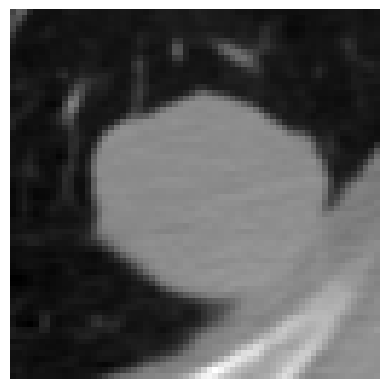

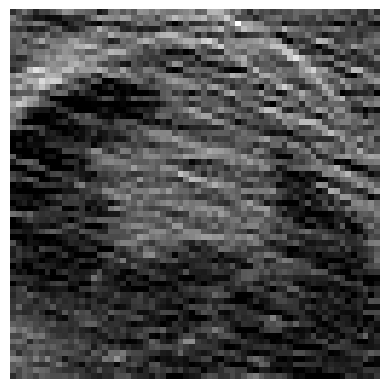

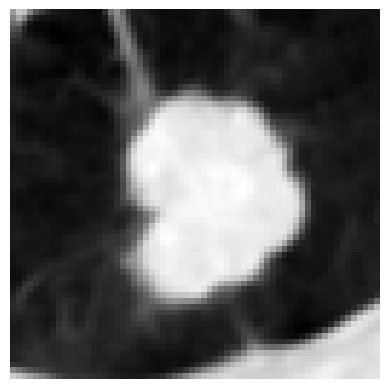

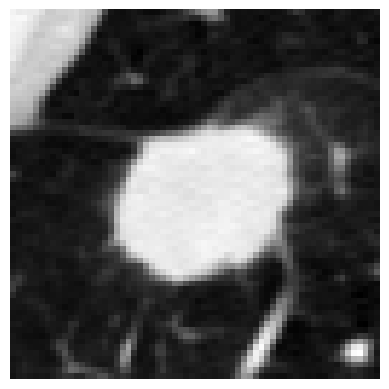

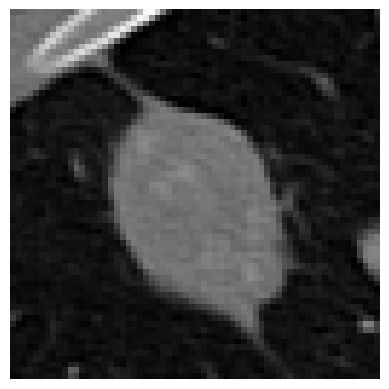

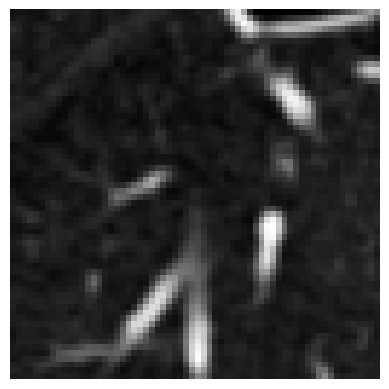

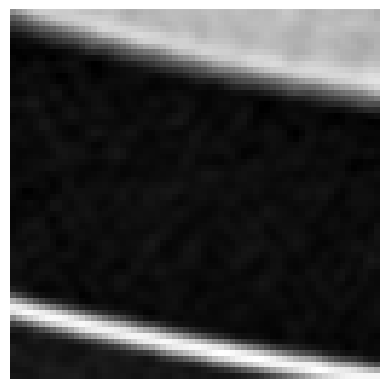

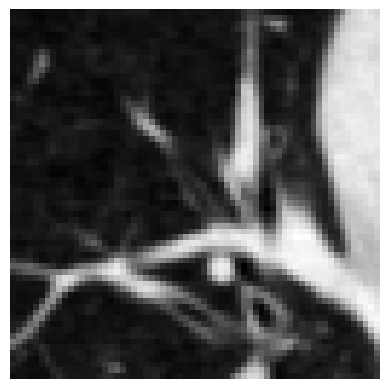

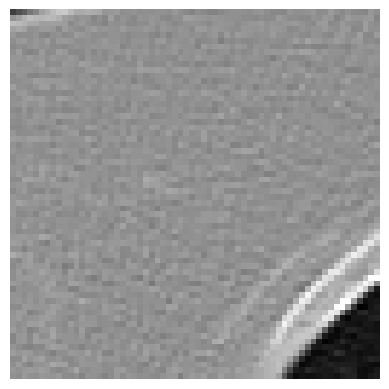

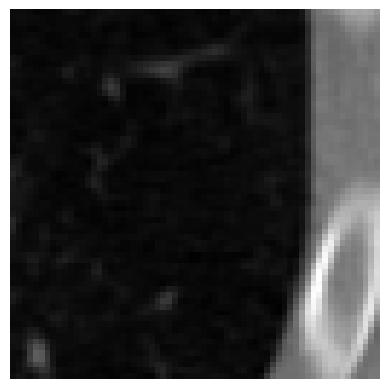

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df_output = pd.read_csv("/kaggle/working/dataset.csv")
# Filter out the nodules and non-nodules
nodules = df_output[df_output['class'] == 1]
non_nodules = df_output[df_output['class'] == 0]
def visualize_slice(slice_path):
    slice_data = np.load(slice_path)
    plt.imshow(slice_data[int(slice_data.shape[0]/2)], cmap='gray')
    plt.axis('off')
    plt.show()
# Visualize 5 nodules
for path in nodules['file'].head(5):
    visualize_slice(path)
# Visualize 5 non-nodules
for path in non_nodules['file'].head(5):
    visualize_slice(path)
